In [1]:
import glob
import os
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform

#IMG_LOC = "/Users/annastuckert/Documents/GitHub/facemap/data/facemap/"
#IMG_LOC = 'C:\\Users\\soren\\Documents\\anna\\facemap\\'
IMG_LOC = 'C:\\Users\\soren\\Documents\\anna\\facemap-main\\data\\schroeder\\'

if os.path.isdir(IMG_LOC + "low_res"):
    print("Folder exists!")
else:
    os.makedirs(IMG_LOC + "low_res")

img_files = sorted(glob.glob(IMG_LOC + "*.png"))
labels = pd.read_csv(IMG_LOC + "labels.csv")
labels_o = pd.read_csv(IMG_LOC + "labels.csv")
labels_o = labels_o.iloc[2:, 2:]
target_o = labels_o.iloc[:, 1:].values
target_o = np.array(target_o, dtype=np.float32)

h = w = 224

# print(img_files.shape)

img = plt.imread(img_files[0])

h_org = img.shape[0]
w_org = img.shape[1]

### Make new labels for low-res

# x_off = (300 - 224) // 2  # (h/h_org*w_org - w) // 2
x_off = (h / h_org * w_org - w) // 2

# Remove the first 3 rows and the first 3 columns from `labels`
labels = labels.iloc[2:, 2:]

target = labels.iloc[:, 1:].values

target = np.array(target, dtype=np.float32)

target = target * h / h_org  # rescale markers
#target[:, 1::2] = target[:, 1::2] * h / h_org  # rescale markers

target[:, ::2] = target[:, ::2] - x_off
#target[:, ::2] = target[:, ::2] * w / w_org


target = torch.Tensor(target)

labels.iloc[:, 1:] = target
labels.to_csv(IMG_LOC + "low_res/labels.csv", index=False)

data = torch.zeros((len(img_files), h, w))
print("Resizing images... \nSaving in torch format")

for i in range(len(img_files)):
    im = plt.imread(img_files[i])[:, :, 0]
    x_start = (w_org - h_org) // 2
    im_cropped = im[:, x_start:x_start + h_org]  # Crop width to h_org, centered

    im_r = (transform.resize(im_cropped, (h, w), anti_aliasing=True) * 255).astype("uint8")
    data[i] = torch.Tensor(im_r / 255.0)
    #io.imsave(IMG_LOC + "low_res/" + img_files[i].split("/")[-1], im_r)
    io.imsave(IMG_LOC + "low_res/" + img_files[i].split("\\")[-1], im_r)

torch.save((data, target), IMG_LOC + "low_res\\schroeder_224.pt")

print("Done! Saved in " + IMG_LOC + "low_res/")

# Load the data and transform `x` and `y` in the correct place
x, y = torch.load(IMG_LOC + "low_res\\schroeder_224.pt")

# Transformations for `x` and `y`
x = x.unsqueeze(1)  # Add channel dimension to x
y = y.numpy()  # Convert y to numpy if needed

print("Data and labels are loaded and transformed.")

torch.save((x, y), "data\\facemap_test_224.pt")



Resizing images... 
Saving in torch format
Done! Saved in C:\Users\soren\Documents\anna\facemap-main\data\schroeder\low_res/
Data and labels are loaded and transformed.


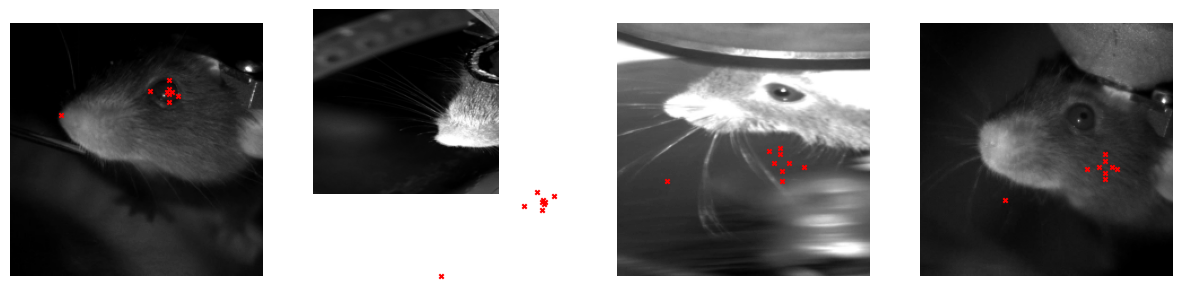

In [7]:
## Function to plot images and keypoints
#def plot_images_with_keypoints(images, keypoints, num_images=5):
#    plt.figure(figsize=(15, 5))
#    for i in range(num_images):
#        img = images[i][0].numpy()  # Get image data
#        kp = keypoints[i].reshape(-1, 2)  # Reshape keypoints
#
#        plt.subplot(1, num_images, i + 1)
#        plt.imshow(img, cmap='gray')
#        plt.scatter(kp[:, 0], kp[:, 1], s=10, c='red', marker='x')
#        plt.axis('off')
#    plt.show()
#
## Plot a few images with keypoints
#plot_images_with_keypoints(x, y, num_images=4)

import random
import matplotlib.pyplot as plt

# Function to plot randomly selected images with keypoints
def plot_images_with_keypoints(images, keypoints, num_images=5):
    # Get random indices for sampling
    random_indices = random.sample(range(len(images)), num_images)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        img = images[idx][0].numpy()  # Get image data
        kp = keypoints[idx].reshape(-1, 2)  # Reshape keypoints

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.scatter(kp[:, 0], kp[:, 1], s=10, c='red', marker='x')
        plt.axis('off')
    plt.show()

# Plot a few randomly selected images with keypoints
plot_images_with_keypoints(x, y, num_images=4)

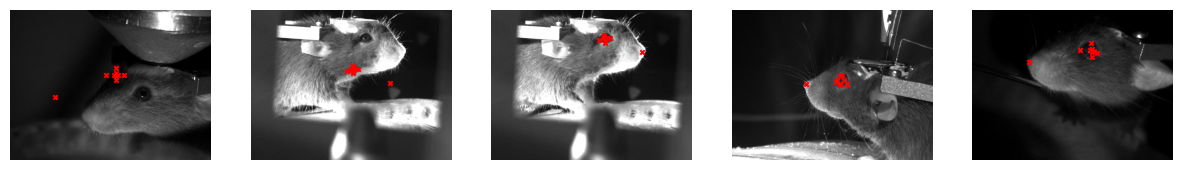

In [36]:
## Function to plot center-cropped original images with keypoints
#def plot_original_images_with_keypoints(image_files, keypoints, num_images=4):
#    plt.figure(figsize=(15, 5))
#    
#    for i in range(num_images):
#        # Load original image
#        img = io.imread(image_files[i])[:, :, 0]  # Load as grayscale
#        kp = keypoints[i].reshape(-1, 2)  # Reshape keypoints
#        
#
#        # Plot image and keypoints
#        plt.subplot(1, num_images, i + 1)
#        plt.imshow(img, cmap='gray')
#        plt.scatter(kp[:, 0], kp[:, 1], s=10, c='red', marker='x')
#        plt.axis('off')
#
#    plt.show()
#
#plot_original_images_with_keypoints(img_files, target_o, num_images=4)


import random
from skimage import io
import matplotlib.pyplot as plt

# Function to plot randomly selected center-cropped original images with keypoints
def plot_original_images_with_keypoints(image_files, keypoints, num_images=4):
    # Get random indices for sampling
    random_indices = random.sample(range(len(image_files)), num_images)
    
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(random_indices):
        # Load original image
        img = io.imread(image_files[idx])[:, :, 0]  # Load as grayscale
        kp = keypoints[idx].reshape(-1, 2)  # Reshape keypoints

        # Plot image and keypoints
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.scatter(kp[:, 0], kp[:, 1], s=10, c='red', marker='x')
        plt.axis('off')

    plt.show()

# Plot a few randomly selected original images with keypoints
plot_original_images_with_keypoints(img_files, target_o, num_images=5)


In [ ]:
import random
from skimage import io
import matplotlib.pyplot as plt

# Function to plot each randomly selected original image with keypoints in a separate figure
def plot_original_images_with_keypoints(image_files, keypoints, num_images=4):
    for i in range(num_images):
        # Load original image
        img = io.imread(image_files[i])[:, :, 0]  # Load as grayscale
        kp = keypoints[i].reshape(-1, 2)  # Reshape keypoints

        # Plot each image and its keypoints in a separate figure
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.scatter(kp[:, 0], kp[:, 1], s=10, c='red', marker='x')
        plt.axis('off')
        plt.title(image_files[i].split('\\')[-1])  # Set the title as the image name
        plt.show()

# Plot a few randomly selected original images with keypoints
plot_original_images_with_keypoints(img_files, target_o, num_images=len(img_files))
